# **Learning trade-off in MGM**
Here we try to show that for any given sequence of observations $$ x_0,x_1,x_2,...,x_t $$ we have a spectrum of explanatory models.

Stochasticity in the observations is explained by different processes in different models for which the likelihood of the observations may be tied.

Specifically we describe an axis in model space defined by two aspects: i) the number of models that may be needed to be combined in order to explain the osbervations ( implied in this are the dynamics of how the different models are combined in time) and ii) the stochasticity of any one of the model componens (whether a model needs to account for all observations).

At the two extremes of this axis, for explaining a stochastic sequence, we have on one extreme i) a bunch of fully deterministic models that  together explain all observations (i.e. stochasticity is absorbed in the switches of model from any time-point to the following time-point) and on the other extreme, we have a single model that has limited predictivity power (i.e. some observations are irreducibly stochastic).

In [1]:
# import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy.random as rnd
#import tensorflow as tf

## Create all dominant patterns within the CTW generative family
Briefly, for any one model we can compute a transition probability matrix, $T_m$ , on the basis of its parameters:

$ T_{\theta^m}  =  \alpha_1*(W_p) + \alpha_2*D^{-1}(E - I - W_p) + \alpha_3*(I)$ 

, where $W_p$ is one of six possible permutation matrices, $E$ is a matrix of ones, and $I$ is the identity matrix, and $ D^{-1} $ is a diagonal matrix that ensures the rows add up to 1, with the constraints that $ \alpha_1 + \alpha_2 + \alpha_3 = 1$ and $ \alpha_1>\alpha_2> \alpha_3>0 $. 

More concretely, if  $ \alpha_1 = 0.66 $ , $ \alpha_2 = 0.33 $ and $ \alpha_3 = 0.01 $, then for the following permutation matrix,

$\begin{equation} 
W^m_p = \begin{bmatrix}  0  &  0  & 1 & 0 \\
0 &  0  &   0  &  1 \\
0  &  1  &  0  &   0 \\
1  &   0  &  0 & 0 \end{bmatrix} 
\end{equation}$

we obtain the following transition probability matrix:

$ T_{\theta^m}   =   \alpha_1\begin{bmatrix}  0  &  0  & 1 & 0 \\
0 &  0  &   0  &  1 \\
0  &  1  &  0  &   0 \\
1  &   0  &  0 & 0 \end{bmatrix} + \alpha_2\begin{bmatrix}  0  &  \tfrac{1}{2}  &  0 & \tfrac{1}{2} \\
\tfrac{1}{2} &  0  &   \tfrac{1}{2}  &  0 \\
\tfrac{1}{2}  &  0  & 0  &   \tfrac{1}{2} \\
0  &   \tfrac{1}{2}  &  \tfrac{1}{2} &  0 \end{bmatrix} + \alpha_3\begin{bmatrix}  1  & 0  &  0 & 0 \\
0 &  1  &  0  &  0 \\
0  &  0  &  1  &   0 \\
0  &   0  &  0 &  1 \end{bmatrix}  = \begin{bmatrix} 0.01  & 0.16  &  0.66  &  0.16 \\
0.16  &  0.01  &  0.16  &  0.66 \\
0.16  &  0.66  &  0.01  &  0.16 \\
0.66  &  0.16  &  0.16  &  0.01 \end{bmatrix}  $ 

Below we create all the permutation matrices within the CTW generative family

 

In [2]:
# start with a vector of zeros (of with 6*4*4 elements)
Wps = np.zeros([6*4*4])
# manually define all the cells that contain a dominant transition
wh_dom = np.array([3,6,8,13,17,23,24,30,34,36,43,45,50,55,57,60,65,70,75,76,83,84,89,94])
Wps[wh_dom] = 1
# reshape into a model*valuein*valueout array
Wps = np.reshape(Wps,[6,4,4])
# select the fourth pattern model as the dominant pattern model
Wp = Wps[3]
#print(Wp)

Here, we define the true generative model, as a matrix of transition probabilities from one state to another. We make use of the (already defined) true dominant pattern and we define and use the true dominant transition probability value:

$ \alpha = 0.75 $

In [3]:
alpha = 0.75
E = np.ones([4,4])
I = np.identity(4)
D = E-I-(Wp)
D = D/np.sum(D,0)
#print(D)
tGM = Wp*alpha + D*(1-alpha)
#print(tGM)

# we can already create the D matrix for all dominant patterns
aE = np.reshape(E,[1,4,4])
aI = np.reshape(I,[1,4,4])
aD = aE-aI-Wps
aD = aD/np.reshape(np.sum(aD,1),[6,1,4])

## Make a simulated sequence of observations
Now, we create a random sequence of 500 transitions as sampled from the true generative model

In [4]:
num_t = 500
in_st = rnd.randint(4)
seq = []
seq_d = []
for it in range(0,num_t):
  p_vec  = tGM[in_st]
  p_cum  = np.cumsum(p_vec)
  rnd_dr = rnd.random_sample()
  is_high = rnd_dr > np.hstack((0, p_cum[0:-1]))
  is_low  = rnd_dr < np.hstack((p_cum[0:-1],1))
  out_st   = is_high&is_low
  out_st_d =  np.argwhere(out_st)
  seq = np.append(seq,out_st)
  seq_d = np.append(seq_d,out_st_d)
  in_st = out_st_d
seq = np.reshape(seq,[num_t,4])
#print(seq)

# convert the sequence from digit format to one-hot encoding
#a = np.int_(seq)
#seq_1h = np.zeros((a.size, a.max()+1))
#seq_1h[np.arange(a.size),a] = 1

Now we want to obtain the likelihood of each transition under each of the possible models within the generative family.
We define a transition as the combination of a pair of consecutive observations indexed by trial $ tr_t = \{ s_{t-1},s_{t} \}$.
We want to obtain the likelihood of an observed transition given a model as parameterised by a permutation matrix and a dominant transition probability value, $\alpha$:

$P(tr_t|Wp_x,\alpha)$


In [5]:
# define transitions as pairs of consecutive observations
x_in  = seq[:-1,:] # from first to second-to-last
x_out = seq[1:,:]  # from second to last

# take care of dimensions to allow for element-wise multiplication
x_in_5d = np.reshape(x_in.T,[1,4,1,(num_t-1),1])
x_out_5d = np.reshape(x_out.T,[1,1,4,(num_t-1),1])

#W = x_in_5d*x_out_5d
n_alph = 101
alphas = np.linspace((1/3),1,n_alph)
alphas_5d = np.reshape(alphas,[1,1,1,1,n_alph])

Wps_5d = np.reshape(Wps,[6,4,4,1,1])
aD_5d  = np.reshape(aD,[6,4,4,1,1])
#print(x_in_5d.shape)
#print(Wps_5d.shape)
#print(alphas_5d.shape)

like_dom_tr = Wps_5d*x_in_5d*x_out_5d*alphas_5d
like_ndom_tr = aD_5d*x_in_5d*x_out_5d*(1-alphas_5d)
like_tr = like_dom_tr+like_ndom_tr


<ipython-input-6-f6e55463e002>:4: RuntimeWarning: divide by zero encountered in log
  loglike_tr = np.log(like_tr_m)


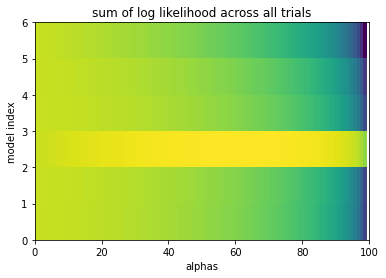

In [6]:
like_tr_m = np.nansum(like_tr,1);
like_tr_m = np.nansum(like_tr_m,1);

loglike_tr = np.log(like_tr_m)
sum_ll_2d  = np.nansum(loglike_tr,1)
#sum_ll_2d.shape
#print(sum_ll_2d)

plt.imshow(sum_ll_2d, extent=[0,100,0,6], aspect='auto',cmap='viridis')
plt.title('sum of log likelihood across all trials')
plt.xlabel('alphas')
plt.ylabel('model index')
plt.show()

Start looking at the likelihood under the assumption of there being a single model throughout the sequence (i.e. zero volatility) for any model within the generative family

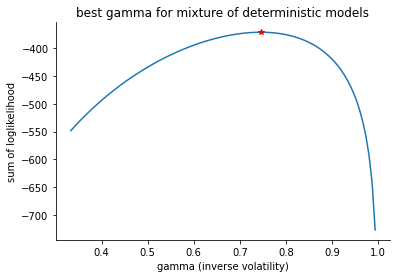

In [7]:
# look at the likelihood curve for the best pattern (i.e., from model 4)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

log_like_for_pat4 = sum_ll_2d[3,]
plt.plot(alphas,log_like_for_pat4)

# mark max
wh_max_llike = np.argwhere(np.max(log_like_for_pat4) == log_like_for_pat4)
plt.plot(alphas[wh_max_llike],np.max(log_like_for_pat4),'r*')

plt.title('best alpha for a single noisy model')
plt.xlabel('alpha (dominant transition probability)')
plt.ylabel('sum of loglikelihood')
plt.show()

Now let's go to the other extreme: a mixture of deterministic models
and compute the likelihood of the transitions under this model

Note: this is still the OLD parameterisation of gamma.
We eventually want to make $$ \gamma = C/(N+C) $$

(6, 6, 99)


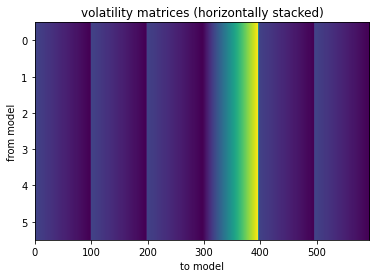

In [8]:
# define the levels of volatility
n_gamm = 99
gammas = np.linspace(0,1,n_gamm)
gammas_3d = np.reshape(gammas,[1,1,n_gamm])
#gammas_6d = np.reshape(gammas,[1,1,1,1,1,n_gamm])
#print(gammas.shape)

# here the volaitility is seen as a diagonal matrix
#vol_I = np.reshape(np.identity(6),[6,6,1])

# we can also see the volaitlity as a rank1 matrix, where model 4 is the most likely model
vol_I = np.reshape(np.zeros([6,6]),[6,6,1])
vol_I[:,3] = 1


# a matrix of ones (used for substracting the gamma part)
vol_E = np.reshape(np.ones([6,6]),[6,6,1])

vol_mat = gammas_3d*vol_I + ((1-gammas_3d)/5)*(vol_E-vol_I)
#print(vol_mat)
print(vol_mat.shape)

vol_mat_slice = vol_mat[:,:,70]
vol_mat_2d = np.reshape(vol_mat,[6,6*99])

plt.imshow(vol_mat_2d,aspect='auto',cmap='viridis')
plt.title('volatility matrices (horizontally stacked)')
plt.xlabel('to model')
plt.ylabel('from model')
plt.show()


In [9]:
# retrieve the likelihood under all deterministic models
like_tr_m_det = like_tr_m[:,:,-1]
print(like_tr_m_det.shape)

# now get the diffused likelihood 
# (i.e. the likelihood after being passed through the volatility matrix)
like_tr_t0 = np.reshape(like_tr_m_det[:,:-1],[6,1,num_t-2,1])
like_tr_t1 = np.reshape(like_tr_m_det[:,1:],[1,6,num_t-2,1])

# print(like_tr_m_det.shape)
# print(like_tr_t0.shape)
# print(like_tr_t1.shape)
vol_mat_4d = np.reshape(vol_mat,[6,6,1,n_gamm])
joint_tr_tr = like_tr_t0*like_tr_t1

like_tr_m_swi = vol_mat_4d*joint_tr_tr

max_like_switch = np.max(like_tr_m_swi,0)
#print(max_like_switch.shape)
max_like_switch = np.max(max_like_switch,0)
#print(max_like_switch.shape)
log_maxlike = np.log(max_like_switch)
sum_log_maxlike = np.nansum(log_maxlike,0)
#print(sum_log_maxlike)

(6, 499)
<ipython-input-9-c05d1a547a17>:22: RuntimeWarning: divide by zero encountered in log
  log_maxlike = np.log(max_like_switch)


<ipython-input-10-a1ac579c8f14>:6: RuntimeWarning: divide by zero encountered in log
  sum_vol_log_like_2d = np.log(np.reshape(sum_vol_like,[6,6*99]))


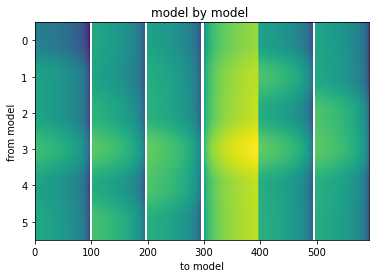

In [10]:
# look at the likelihood of the difussion matrix for different values of gamma
#print(like_tr_m_swi.shape)

# get cumulative likelihood of each model to model transition (for each gamma)
sum_vol_like = np.nansum(like_tr_m_swi,2)
sum_vol_log_like_2d = np.log(np.reshape(sum_vol_like,[6,6*99]))

# now plot it
plt.imshow(sum_vol_log_like_2d,aspect='auto',cmap='viridis')
plt.title('model by model ')
plt.xlabel('to model')
plt.ylabel('from model')
plt.show()

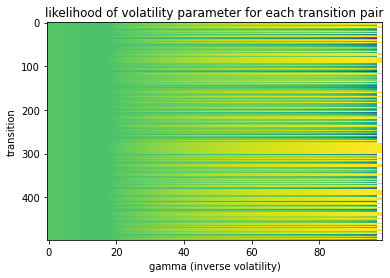

In [11]:
#plt.imshow(log_maxlike,extent=[0,n_gamm,num_t-2,0], aspect='auto',cmap='viridis')
plt.imshow(log_maxlike, aspect='auto',cmap='viridis')
plt.title('likelihood of volatility parameter for each transition pair')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')
plt.show()

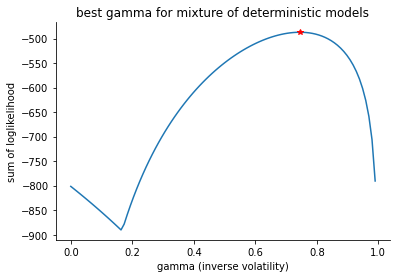

In [12]:
# marginalising over transitions
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(gammas,sum_log_maxlike)

# mark max
wh_max_llike = np.argwhere(np.max(sum_log_maxlike) == sum_log_maxlike)
plt.plot(gammas[wh_max_llike],np.max(sum_log_maxlike),'r*')

plt.title('best gamma for mixture of deterministic models')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('sum of loglikelihood')
plt.show()

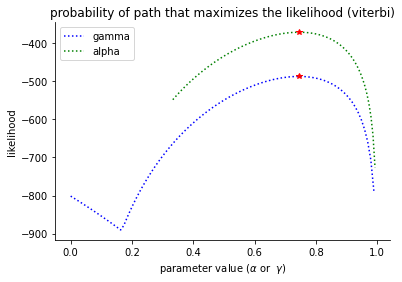

In [13]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

line1 = plt.plot(gammas,sum_log_maxlike,'b:')

log_like_for_pat4 = sum_ll_2d[3,]
line2 = plt.plot(alphas,log_like_for_pat4,'g:')

# mark max gamma
wh_max_llike = np.argwhere(np.max(sum_log_maxlike) == sum_log_maxlike)
plt.plot(gammas[wh_max_llike],np.max(sum_log_maxlike),'r*')

# mark max alpha
wh_max_llike = np.argwhere(np.max(log_like_for_pat4) == log_like_for_pat4)
plt.plot(alphas[wh_max_llike],np.max(log_like_for_pat4),'r*')


plt.title('probability of path that maximizes the likelihood (viterbi)')
plt.ylabel('likelihood')
plt.xlabel('parameter value (' r'$\alpha$ or  $\gamma$)')
ax.legend(['gamma','alpha'])
plt.show()

## Obtain the posterior over models at each timestep
for this we have a likelihood of a transition at each timestep (given each model) which gets diffused in time via the volatility matrix

In [14]:
# define variables and shapes
prior_m = np.ones([6,1,num_t,n_gamm])/6
post_m = np.zeros(np.shape(prior_m))
like_tr_m_det_rshp = np.reshape(like_tr_m_det,[6,1,num_t-1,1])

# we do this in a loop
for it in range(num_t-1):

    # combine prior and likelihood
    i_post = prior_m[:,:,it,:]*like_tr_m_det_rshp[:,:,it]
    norm_post = i_post/np.nansum(i_post,axis=0)
    post_m[:,:,it,:] = norm_post

    # diffuse the posterior (though volatility matrix) to get prior for next trial  
    diff_post = post_m[:,:,it,:]*vol_mat_4d
    prior_m[:,:,it+1,:] = np.sum(diff_post,axis=1)

#jont_tr_tr = like_tr_t0*like_tr_t1;
#like_tr_m_swi = vol_mat_4d*joint_tr_tr;

<ipython-input-14-5ca2d2a7a087>:11: RuntimeWarning: invalid value encountered in true_divide
  norm_post = i_post/np.nansum(i_post,axis=0)


In [15]:
ig = 20
it = 34
W1 = np.reshape(prior_m[:,:,it+1,:],[6,99])
W2 = np.reshape(prior_m[:,:,:,ig],[6,num_t])
W3 = np.reshape(post_m[:,:,it,:],[6,99])
W4 = np.reshape(post_m[:,:,:,ig],[6,num_t])
'''
fig = plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(W1, aspect='auto',cmap='viridis')
plt.title('prior for trial t')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')

plt.subplot(2, 2, 2)
plt.imshow(W2, aspect='auto',cmap='viridis')
plt.title('prior for all trials at a set gamma')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')

plt.subplot(2, 2, 3)
plt.imshow(W3, aspect='auto',cmap='viridis')
plt.title('posterior for trial t-1')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')

plt.subplot(2, 2, 4)
plt.imshow(W4, aspect='auto',cmap='viridis')
plt.title('posterior for all trials')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')

plt.show()
'''

"\nfig = plt.figure()\nplt.subplot(2, 2, 1)\nplt.imshow(W1, aspect='auto',cmap='viridis')\nplt.title('prior for trial t')\nplt.xlabel('gamma (inverse volatility)')\nplt.ylabel('transition')\n\nplt.subplot(2, 2, 2)\nplt.imshow(W2, aspect='auto',cmap='viridis')\nplt.title('prior for all trials at a set gamma')\nplt.xlabel('gamma (inverse volatility)')\nplt.ylabel('transition')\n\nplt.subplot(2, 2, 3)\nplt.imshow(W3, aspect='auto',cmap='viridis')\nplt.title('posterior for trial t-1')\nplt.xlabel('gamma (inverse volatility)')\nplt.ylabel('transition')\n\nplt.subplot(2, 2, 4)\nplt.imshow(W4, aspect='auto',cmap='viridis')\nplt.title('posterior for all trials')\nplt.xlabel('gamma (inverse volatility)')\nplt.ylabel('transition')\n\nplt.show()\n"

In [16]:

it = 24
vol_mat_3d = np.reshape(vol_mat_4d,[6,6,n_gamm])
# get trial t posterior
i_post_t0 = np.reshape(post_m[:,:,it,:],[6,1,n_gamm])

# get the likelihood of the transition at time t+1 and t+2
i_like_t1 = np.reshape(like_tr_m_det_rshp[:,:,it+1],[1,6,1])
i_like_t2 = np.reshape(like_tr_m_det_rshp[:,:,it+2],[1,6,1])

# compute the likelihood of paths from post_t0 to like_t1 and from like_t1 to like_t2 
i_path1_like = i_post_t0*vol_mat_3d*i_like_t1
i_path2_like = np.reshape(i_like_t1,[6,1,1])*vol_mat_3d*i_like_t2

# maximum likelihood path t1 (from posterior at time t0 to likelihood at time t+1)
max_like_path1 = np.max(np.sum(i_path1_like,axis=0),axis=(1))
max_like_path2 = np.max(np.sum(i_path2_like,axis=0),axis=(1))# np.max(i_path2_like,axis=(1))


#print(max_like1[:,:,75])
print(np.squeeze(i_post_t0[:,:,75]))
print(np.squeeze(i_like_t1))
print(np.squeeze(i_path1_like[:,:,75]))
#print(max_like_path1)
#print(np.squeeze(np.sum(like_path1b[:,:,:,75],axis=1)))


[0.5 0.  0.5 0.  0.  0. ]
[0. 1. 0. 1. 0. 0.]
[[0.         0.02346939 0.         0.38265306 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.02346939 0.         0.38265306 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [17]:
vol_mat_3d = np.reshape(vol_mat_4d,[6,6,n_gamm])
like_mix_det_mod = np.ones([num_t,n_gamm])/6

for it in range(num_t-3):
    # get trial t posterior
    i_post_t0 = np.reshape(post_m[:,:,it,:],[6,1,n_gamm])

    # get the likelihood of the transition at time t+1 and t+2
    i_like_t1 = np.reshape(like_tr_m_det_rshp[:,:,it+1],[1,6,1])

    # compute the likelihood of paths from post_t0 to like_t1 and from like_t1 to like_t2 
    i_path1_like = i_post_t0*vol_mat_3d*i_like_t1

    # maximum likelihood path t1 (from posterior at time t0 to likelihood at time t+1)
    max_like_path1 = np.max(np.sum(i_path1_like,axis=0,keepdims=1),axis=1)

    like_mix_det_mod[it+1,:] = np.log(max_like_path1)
#jont_tr_tr = like_tr_t0*like_tr_t1;

<ipython-input-17-bc8573e32665>:17: RuntimeWarning: divide by zero encountered in log
  like_mix_det_mod[it+1,:] = np.log(max_like_path1)


In [18]:
'''
#plt.imshow(log_maxlike,extent=[0,n_gamm,num_t-2,0], aspect='auto',cmap='viridis')
plt.imshow(like_mix_det_mod, aspect='auto',cmap='viridis')
plt.title('likelihood of volatility parameter for each transition pair')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')
plt.show()
'''

"\n#plt.imshow(log_maxlike,extent=[0,n_gamm,num_t-2,0], aspect='auto',cmap='viridis')\nplt.imshow(like_mix_det_mod, aspect='auto',cmap='viridis')\nplt.title('likelihood of volatility parameter for each transition pair')\nplt.xlabel('gamma (inverse volatility)')\nplt.ylabel('transition')\nplt.show()\n"

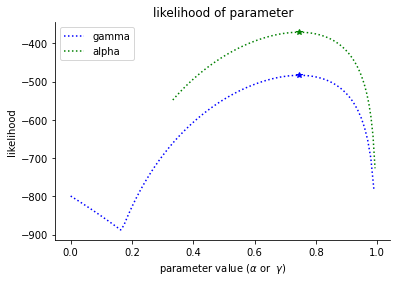

In [19]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sum_log_like_mix_det_mod = np.nansum(like_mix_det_mod,axis=0)


line1 = plt.plot(gammas,sum_log_like_mix_det_mod,'b:')

log_like_for_pat4 = sum_ll_2d[3,]
line2 = plt.plot(alphas,log_like_for_pat4,'g:')


# mark max gamma
wh_max_llike = np.argwhere(np.max(sum_log_like_mix_det_mod) == sum_log_like_mix_det_mod)
plt.plot(gammas[wh_max_llike],np.max(sum_log_like_mix_det_mod),'b*')

# mark max alpha
wh_max_llike = np.argwhere(np.max(log_like_for_pat4) == log_like_for_pat4)
plt.plot(alphas[wh_max_llike],np.max(log_like_for_pat4),'g*')


plt.title('likelihood of parameter')
plt.ylabel('likelihood')
plt.xlabel('parameter value (' r'$\alpha$ or  $\gamma$)')
ax.legend(['gamma','alpha'])
plt.show()